<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/RISE_MICCAI_Winter_School_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation Tutorial for RISE-MICCAI Winter School

Author of this tutorial: [Wenjia Bai](https://www.doc.ic.ac.uk/~wbai)

Last modified: 11/11/2022

In this tutorial, you will develop and train a convolutional neural network for brain tumour image segmentation. Please read the text and code and fill in the missing code blocks that look like this:

```
### Insert your code ###
[Insert your code here]
### End of your code ###
```

When you train the network, you may need to use the GPU resources on Google Colab. Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## Download the imaging dataset

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2022-11-22 11:22:03--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2022-11-22 11:22:03--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb62b0e098a8098974da3a55a58.dl.dropboxusercontent.com/cd/0/inline/BxNpp_kcz7uB3MCng_wAuf9uD-cKltwqcu5bRt4v6JzxZMcV-IjxQDB9Pe7mod75xdlh7tb-qEiETUX2TXPyGDN9NIhyiQpGGgZ1bLTa83VUxTBUwdK0exnAp-Olikyi65WU_Z9zc8efV7VVy_BpHtGXmBVpmG-TDx2sAijWgNtbPA/file# [following]
--2022-11-22 11:22:04--  https://ucb62b0e098a8098974da3a55a58.dl.dropboxusercontent.com/cd/0/inline/BxNpp_kcz7uB3MCng_wAuf9uD-cKl

# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [30]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        batch_idx = random.sample(range(0, self.__len__()), batch_size)
        for i in range(batch_size):
            image, label = self.__getitem__(batch_idx[i])
            images.append(image)
            labels.append(label)
        
        ### End of your code ###
        images, labels = np.array(images), np.array(labels)
        images = np.expand_dims(images, 1)
        return images, labels

In [31]:
import random
random.sample(range(0, 20), 10)

[10, 7, 15, 8, 16, 5, 14, 4, 17, 0]

# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [49]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        n = int(n / 2)  # 64
        self.up3 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up3 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        self.up2 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up2 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 16
        self.up1 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up1 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Output
        self.out = nn.Conv2d(n, output_channel, kernel_size=1, padding=0)

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = torch.cat((self.up3(x), conv3_skip), dim=1)
        x = self.conv_up3(x)
        x = torch.cat((self.up2(x), conv2_skip), dim=1)
        x = self.conv_up2(x)
        x = torch.cat((self.up1(x), conv1_skip), dim=1)
        x = self.conv_up1(x)
        
        ### End of your code ###
        x = self.out(x)
        return x

# Train the segmentation model

In [52]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)
    
    # Note that optimizer.zero_grad() is equivalent to net.zero_grad() if it optimises all the net parameters.
    optimizer.zero_grad()

    # Perform optimisation
    ### Insert your code ###
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    ### End of your code ###

    print('--- Iteration {0}: Training loss = {1:.4f}, {2:.4f} s ---'.format(it, loss.item(), time.time() - start_iter))

    # Evaluate
    if it % 10 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            loss = criterion(logits, labels)
            print('--- Iteration {0}: Test loss = {1:.4f} ---\n'.format(it, loss.item()))

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Streaming output truncated to the last 5000 lines.
--- Iteration 5836: Training loss = 0.0181, 0.0440 s ---
--- Iteration 5837: Training loss = 0.0132, 0.0429 s ---
--- Iteration 5838: Training loss = 0.0186, 0.0435 s ---
--- Iteration 5839: Training loss = 0.0102, 0.0433 s ---
--- Iteration 5840: Training loss = 0.0215, 0.0438 s ---
--- Iteration 5840: Test loss = 0.0356 ---

--- Iteration 5841: Training loss = 0.0162, 0.0452 s ---
--- Iteration 5842: Training loss = 0.0152, 0.0449 s ---
--- Iteration 5843: Training loss = 0.0113, 0.0429 s ---
--- Iteration 5844: Training loss = 0.0084, 0.0426 s ---
--- Iteration 5845: Training loss = 0.0073, 0.0420 s ---
--- Iteration 5846: Training loss = 0.0112, 0.0426 s ---
--- Iteration 5847: Training loss = 0.0121, 0.0436 s ---
--- Iteration 5848: Training loss = 0.0121, 0.0465 s ---
--- Iteration 5849: Training loss = 0.0119, 0.0426 s ---
--- Iteration 5850: Training loss = 0.0090, 0.0424 s ---
--- Iteration 5850: Test loss = 0.0376 ---

--- It

# Visualise the segmentation results

In [71]:
# Get a random batch of test images
# Segment the images using the trained model
images, labels = test_set.get_random_batch(4)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
model.eval()
logits = model(images)
prob = F.softmax(logits, dim=1)
seg = torch.argmax(prob, dim=1)

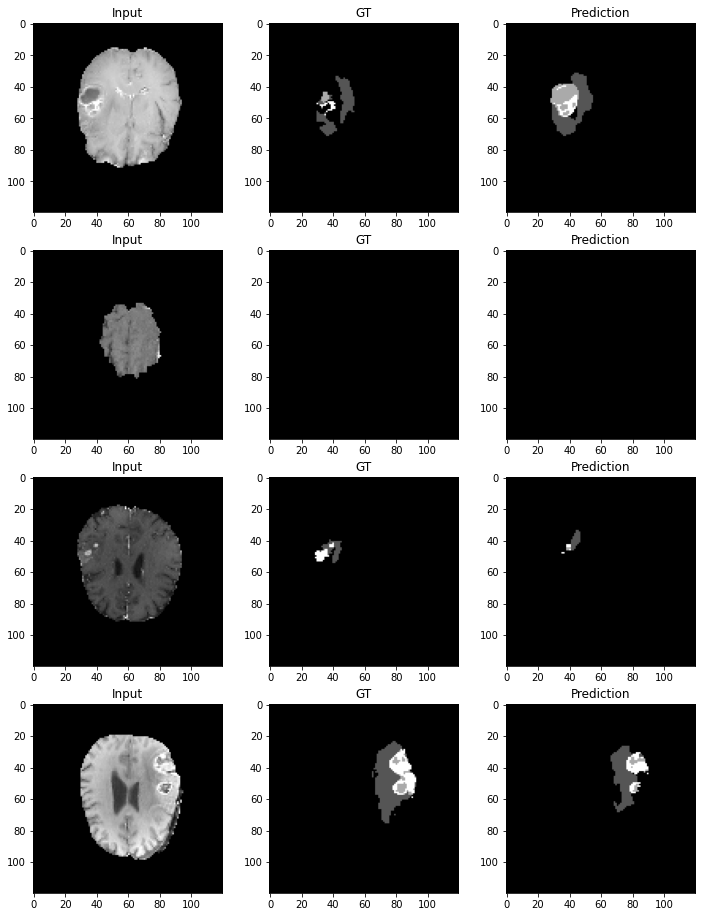

In [72]:
# Visualise the image, automated segmentation and manual segmentation
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
### Insert your code ###
for i in range(4):
    axs[i,0].imshow(images[i,0].cpu(), cmap='gray')
    axs[i,0].set_title('Input')
    axs[i,1].imshow(labels[i].cpu(), cmap='gray')
    axs[i,1].set_title('GT')
    axs[i,2].imshow(seg[i].cpu(), cmap='gray')
    axs[i,2].set_title('Prediction')
### End your code ###